In [1]:
import cppyy
import cppyy.gbl as cpp
from cppyy.gbl import std

from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

ERROR in cling::CIFactory::createCI(): cannot extract standard library include paths!
Invoking:
  LC_ALL=C /Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin/c++    -xc++ -E -v /dev/null 2>&1 | sed -n -e '/^.*include/,${' -e '/^ \/.*++/p' -e '}'
Results was:
With exit code 0
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cppyy.include('../include/micrograd/engine.hpp')
cppyy.include('../include/micrograd/nn.hpp')

True

In [3]:
(raw_train_X, raw_train_y), (raw_test_X, raw_test_y) = mnist.load_data()
train_X = std.vector[std.vector[float]]()
train_y = std.vector[std.vector[float]]()
test_X = std.vector[std.vector[float]]()
test_y = std.vector[std.vector[float]]()

[train_X.push_back(std.vector[float](list(x.flatten()/255 - 0.5))) for x in raw_train_X];
[train_y.push_back(std.vector[float](list(np.eye(10)[y]))) for y in raw_train_y];
[test_X.push_back(std.vector[float](list(x.flatten()/255 - 0.5))) for x in raw_test_X];
[test_y.push_back(std.vector[float](list(np.eye(10)[y]))) for y in raw_test_y];

11490434/11490434 [==============================] - 2s 0us/step


2


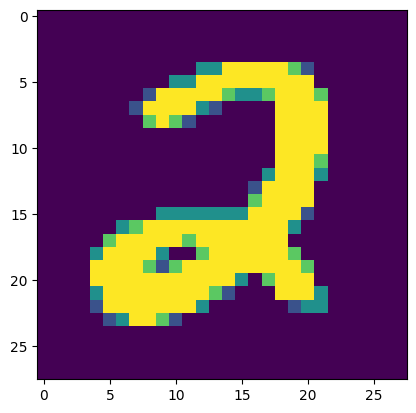

In [4]:
test_ind = np.random.randint(0, len(raw_train_X))
plt.imshow(raw_train_X[test_ind])
print(raw_train_y[test_ind])

In [8]:
output = 10
mnist_model = cpp.MLP[float,3](784,[100, 30, output])

In [11]:
BATCH = 50
EPOCHS = 3
LOSSES = []
running_loss = 0

for i in range(EPOCHS):
    for j in range(0, len(train_X), BATCH):
        for k in range(min(BATCH, len(train_X)-j)):
            
            prediction = mnist_model(train_X[j+k])
            
            tmp = cpp.Value[float](0)
            
            #for i in range(output):
             #   tmp += (prediction[i] - train_y[j+k][i])
            
            loss = prediction**2
            
            loss.backward()
            
            running_loss += loss.data
            
        for parameter in mnist_model.parameters():
            parameter.data += -0.0005 * parameters.grad
            
        mnist_model.zero_grad()
        print(f"Epoch: {i}, Batch: {j}, Loss: {running_loss/k}")
        running_loss = 0.0

TypeError: unsupported operand type(s) for ** or pow(): 'vector<value_engine::Value<float>>' and 'int'

In [14]:
count = 0
for x, y in zip(test_X, test_y):
    if np.argmax([val.get_data() for val in mnist_model(x)]) == np.argmax(y):
        count += 1
print(f"Accuracy: {count/len(test_X)}")

Accuracy: 0.8485


In [15]:
test_dict = dict()

for i, (x, y) in enumerate(zip(test_X, test_y)):
    prediction = np.argmax([val.get_data() for val in mnist_model(x)])
    test_dict[i] = (prediction, np.argmax(y))

fail_dict = {k:v for k,v in test_dict.items() if v[0] != v[1]}

Prediction: 3, Actual: 2


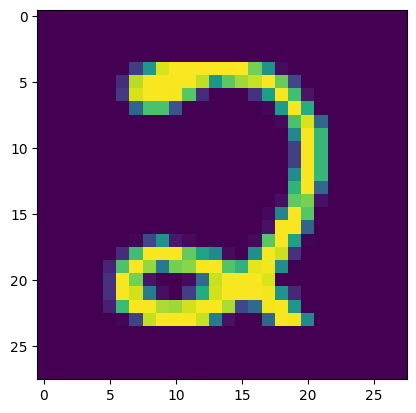

In [27]:
def visualise_error(ind):
    plt.imshow(raw_test_X[ind])
    print(f"Prediction: {fail_dict[ind][0]}, Actual: {fail_dict[ind][1]}")

all_fail = list(fail_dict.keys())

visualise_error(all_fail[10])